# SAMBA tutorial

This is a demonstrative tutorial notebook to show the functions of SAMBA. It can be run locally due to the small size of the toy model.
SAMBA is meant to be used on a computing cluster using Snakemake as large models require more resources to sample.

## Variables and input files

In [1]:
from pipeline.scripts import export_ids, export_scenario_ids, calc_zscore, append_zscores
from local.scripts import main, export_dicts
import cobra
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
biomass_opt = 0.1
n_samples = 1000

In [3]:
# Metabolic network to be used:
model_path = "input_files/small4M_ex_pathways2.xml"

# Table containing different scenarios we want to test with the corresponding IDs to KO in the model. Here, the IDS are reaction IDS, but they can be gene IDs.
ko_ids_file = "input_files/small4M_rxns_to_KO.tsv"

# Output path for all outputs. Subfolders will be created automatically.
out_path = "output_files/"

In [4]:
model = cobra.io.read_sbml_model(model_path)
model

<Model small4M_ex_pathways2 at 0x7fb5fb2cb550>

The model we will be using is a toy model containing 19 metabolites, 8 of which can be imported/exported, and 25 reactions. It has two compartments shown in blue and green in the image below.

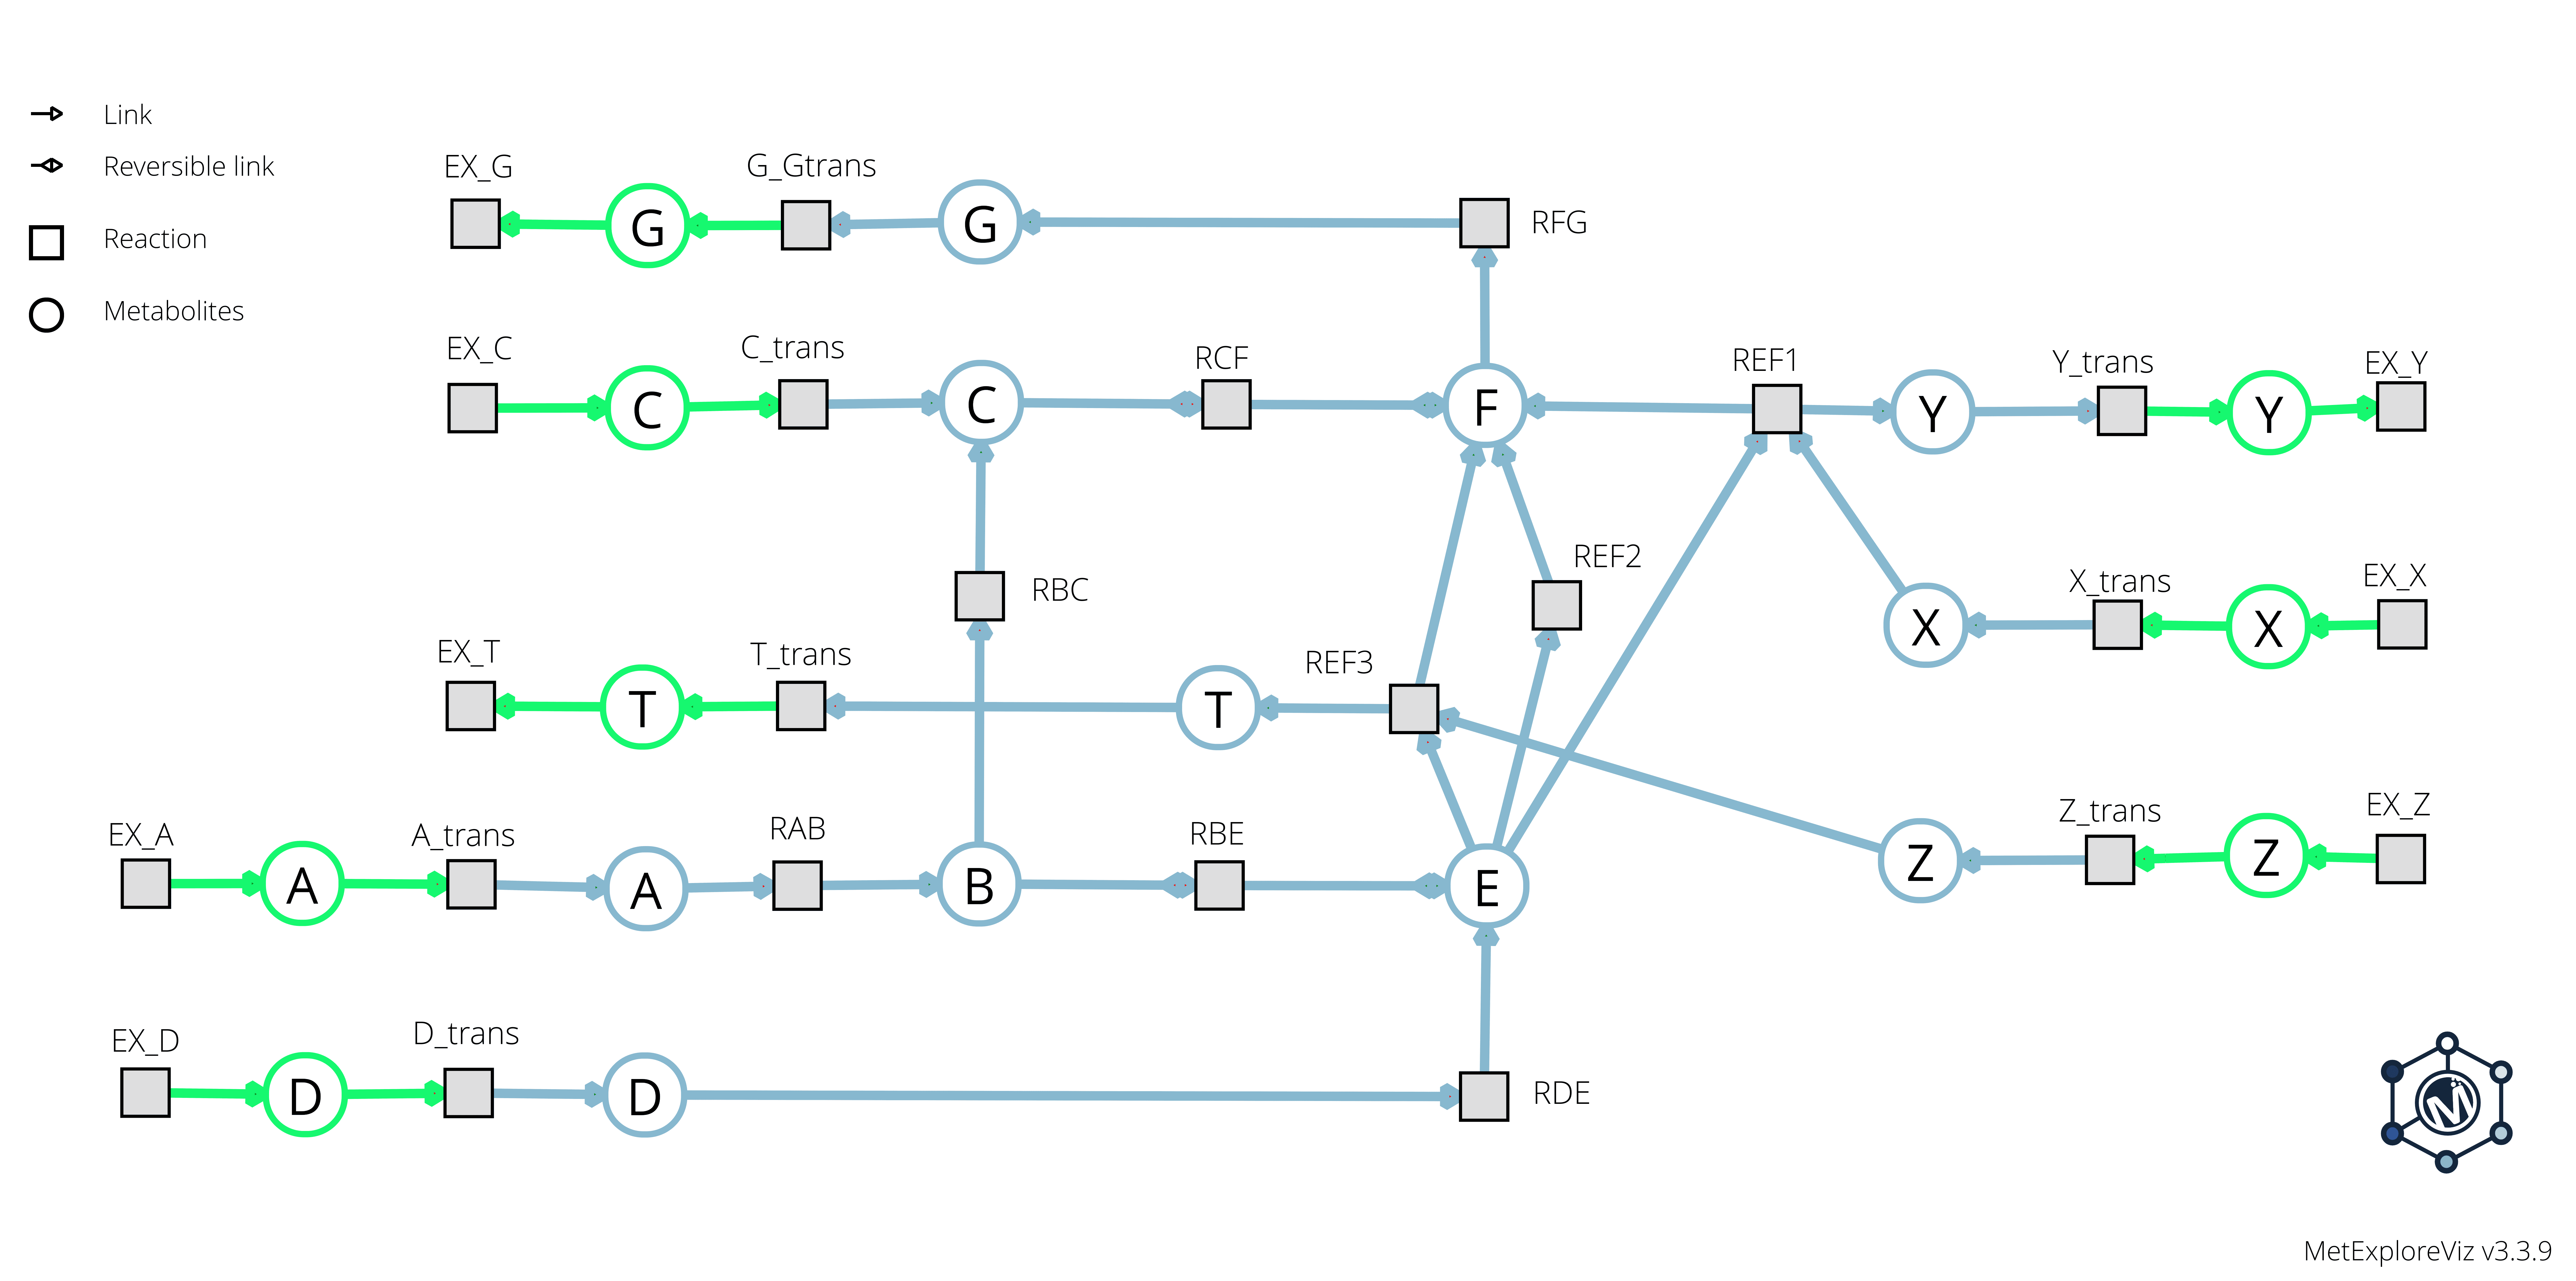

In [5]:
Image(filename='MetExploreViz_10-21-2023_high.png')

The 3 toy KO scenarios we will be testing are the following:

In [6]:
pd.read_csv(ko_ids_file, sep="\t")

Scenario       IDs
0   Disease 5      REF1
1        KO 8       RAB
2  scenario 3  RBC REF1

## Set-up
Generate KO identifiers in a format readable by SAMBA and write them into separate files.

In [7]:
ko_dict = export_ids.main(["-m", model_path, "-o", out_path+"ids/", "-i", ko_ids_file, "-l"])

Detected reaction IDs.
Wrote file: output_files/ids/scenario_1.txt
Wrote file: output_files/ids/scenario_2.txt
Wrote file: output_files/ids/scenario_3.txt


The export_ids function has renamed all scenarios to a harmonised format.

In [8]:
print(ko_dict)

{'scenario_1': 'REF1', 'scenario_2': 'RAB', 'scenario_3': 'RBC REF1'}


Create a scenario dictionary file for mapping back to original names if needed.

In [9]:
export_scenario_ids.main(["-d", out_path+"dict/scenario_dict.tsv", "-c", "simple", "-i", ko_ids_file])
pd.read_csv(out_path+"dict/scenario_dict.tsv", sep="\t")

Scenario    Filename
0   Disease 5  scenario_1
1        KO 8  scenario_2
2  scenario 3  scenario_3

## Sampling
### WT
Sample the base model with no changes to the model.
SAMBA samples the fluxes of exchange reactions.

In [10]:
main.main(["-m", model_path, "-n", str(n_samples), "-o", out_path+"raw_samples/", "-b", str(biomass_opt), "--biomassrxn",
            "input_files/biomass_dict.tsv", "--exchangemin", '1', "--results", "exchanges", "--scenario", "wt",
            "-p", '4', "--solver", "glpk"])

INFO:Importing model...
INFO:Detected .xml model.
INFO:The current solver interface glpk doesn't support setting the optimality tolerance.
INFO:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.
INFO:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.
INFO:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.
INFO:The current solver interface glpk doesn't support setting the optimality tolerance.
INFO:Objective: Maximize
1.0*RBE - 1.0*RBE_reverse_1b98c
INFO:Final obj value: 0.1*1000.0=100.0
INFO:Starting sampling...
INFO:The current solver interface glpk doesn't support setting the optimality tolerance.
INFO:Total elapsed time: 1.68 sec
INFO:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.
INFO:Compartment `e` sounds like an external compartment. Using this one without counti

Column names extraction time: 0.003721952438354492
s_results round time: 0.014217138290405273
Wrote to output_files/raw_samples/default__sampling__WT.csv.gz


In [11]:
wt_samples = pd.read_csv(out_path+"raw_samples/default__sampling__WT.csv.gz", compression="gzip")
wt_samples

EX_A     EX_D     EX_X    EX_C     EX_Z     EX_G     EX_Y     EX_T
0    408.082  398.731  140.313  62.451  414.349  869.264  140.313  414.349
1    669.960   34.278  282.504  60.722    7.136  764.960  282.504    7.136
2    573.653   30.293  411.489   2.936   39.948  606.882  411.489   39.948
3    936.618   16.780   31.909   0.072  410.239  953.469   31.909  410.239
4    881.861   43.094  163.342  72.270  410.061  997.226  163.342  410.061
..       ...      ...      ...     ...      ...      ...      ...      ...
995  325.252  550.142   72.709  38.544  403.136  913.938   72.709  403.136
996  557.997  280.816  195.181   2.501  200.690  841.314  195.181  200.690
997  372.055  484.515  466.546  73.525  265.227  930.095  466.546  265.227
998  545.203  358.823  312.409  48.750  244.401  952.776  312.409  244.401
999  530.955   72.567  140.718  98.063   35.941  701.585  140.718   35.941

[1000 rows x 8 columns]

<Axes: xlabel='EX_A', ylabel='Density'>

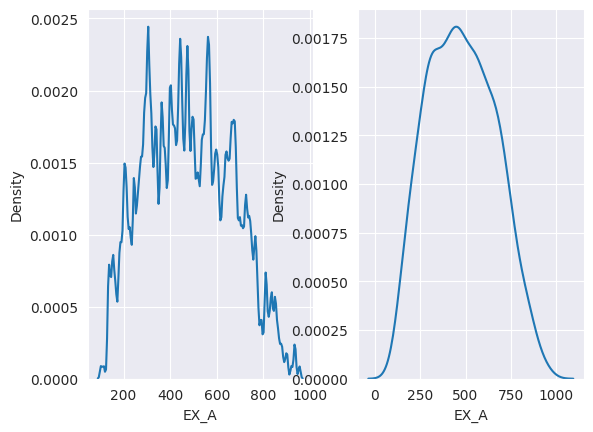

In [12]:
# Plot the density of one of the reactions:
fig, ax = plt.subplots(1,2)
sns.kdeplot(wt_samples.EX_A, bw_adjust=0.1, ax=ax[0])
sns.kdeplot(wt_samples.EX_A, ax=ax[1])

Depending on the smoothing, the distribution can appear jagged or smooth. More samples (here we only used 1000) results in a smoother distribution.

### KO
Sample the model but input IDs to KO, which will change the model state.

In [13]:
for scenario, rxns_to_ko in ko_dict.items():
    print(rxns_to_ko)
    main.main(["-m", model_path, "-n", str(n_samples), "-o", out_path+"raw_samples/", "-b", str(biomass_opt), "--biomassrxn",
               "input_files/biomass_dict.tsv", "--exchangemin", '1', "--results", "exchanges", "--scenario", "ko",
               "-p", '4', "--solver", "glpk",
               "-k", out_path+"/ids/"+scenario+".txt"])

INFO:Importing model...
INFO:Detected .xml model.
INFO:The current solver interface glpk doesn't support setting the optimality tolerance.
INFO:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.
INFO:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.
INFO:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.
INFO:The current solver interface glpk doesn't support setting the optimality tolerance.
INFO:scenario_1
INFO:FBA sol: 1000.0
INFO:Objective: Maximize
1.0*RBE - 1.0*RBE_reverse_1b98c
INFO:Final obj value: 0.1*1000.0=100.0
INFO:Reducing flux to 0.000000% of its maximum.
INFO:Objective: Maximize
1.0*RBE - 1.0*RBE_reverse_1b98c
INFO:Final obj value: 0.1*1000.0=100.0
INFO:Starting sampling...
INFO:The current solver interface glpk doesn't support setting the optimality tolerance.
INFO:Skipping fixed reaction REF1
INFO:Skipping fi

REF1


INFO:Total elapsed time: 2.17 sec
INFO:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.
INFO:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.
INFO:Importing model...
INFO:Detected .xml model.
INFO:The current solver interface glpk doesn't support setting the optimality tolerance.
INFO:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.
INFO:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.
INFO:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.
INFO:The current solver interface glpk doesn't support setting the optimality tolerance.
INFO:scenario_2
INFO:FBA sol: 1000.0
INFO:Objective: Maximize
1.0*RBE - 1.0*RBE_reverse_1b98c
INFO:Final obj value: 0.1*1000.0=100.0
INFO:Reducing flux to 0.000000% of its maximum.
INFO:Ob

Column names extraction time: 0.0030171871185302734
s_results round time: 0.0023810863494873047
Wrote to output_files/raw_samples/scenario_1__sampling__KO.csv.gz
RAB


INFO:Total elapsed time: 1.85 sec
INFO:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.
INFO:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.
INFO:Importing model...
INFO:Detected .xml model.
INFO:The current solver interface glpk doesn't support setting the optimality tolerance.
INFO:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.
INFO:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.
INFO:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.
INFO:The current solver interface glpk doesn't support setting the optimality tolerance.
INFO:scenario_3
INFO:FBA sol: 1000.0
INFO:FBA sol: 1000.0
INFO:Objective: Maximize
1.0*RBE - 1.0*RBE_reverse_1b98c
INFO:Final obj value: 0.1*950.0=95.0
INFO:Reducing flux to 0.000000% of i

Column names extraction time: 0.004812717437744141
s_results round time: 0.0043201446533203125
Wrote to output_files/raw_samples/scenario_2__sampling__KO.csv.gz
RBC REF1


INFO:Total elapsed time: 1.94 sec
INFO:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.
INFO:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.


Column names extraction time: 0.002772808074951172
s_results round time: 0.0030536651611328125
Wrote to output_files/raw_samples/scenario_3__sampling__KO.csv.gz


In [14]:
ko1_samples = pd.read_csv(out_path+"raw_samples/scenario_1__sampling__KO.csv.gz", compression="gzip")
ko1_samples

EX_A     EX_D  EX_X     EX_C     EX_Z     EX_G  EX_Y     EX_T
0    634.326  193.494   0.0  169.077  150.902  996.898   0.0  150.902
1    162.386  279.442   0.0  442.285  181.687  884.112   0.0  181.687
2    139.100  259.765   0.0  474.564   83.886  873.429   0.0   83.886
3    495.790   65.943   0.0  220.716   96.984  782.449   0.0   96.984
4    788.565   52.707   0.0   16.567  372.720  857.840   0.0  372.720
..       ...      ...   ...      ...      ...      ...   ...      ...
995  675.599   92.561   0.0  132.944  603.221  901.104   0.0  603.221
996  581.657  302.666   0.0    9.630  305.376  893.952   0.0  305.376
997  548.053   19.303   0.0  193.599   13.610  760.954   0.0   13.610
998  291.670  425.760   0.0   38.064    3.086  755.494   0.0    3.086
999  305.919    5.166   0.0  571.500   14.895  882.585   0.0   14.895

[1000 rows x 8 columns]

### Flux distributions

In [15]:
# Join wt_samples and ko1_samples
all_samples = wt_samples.melt(value_name="WT").join(ko1_samples.melt(value_name="KO").drop("variable",axis=1)).rename(columns={"variable":"rxn"}).melt(id_vars="rxn",value_vars = ["WT", "KO"])
all_samples

rxn variable    value
0      EX_A       WT  408.082
1      EX_A       WT  669.960
2      EX_A       WT  573.653
3      EX_A       WT  936.618
4      EX_A       WT  881.861
...     ...      ...      ...
15995  EX_T       KO  603.221
15996  EX_T       KO  305.376
15997  EX_T       KO   13.610
15998  EX_T       KO    3.086
15999  EX_T       KO   14.895

[16000 rows x 3 columns]

/home/juliette/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/juliette/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)


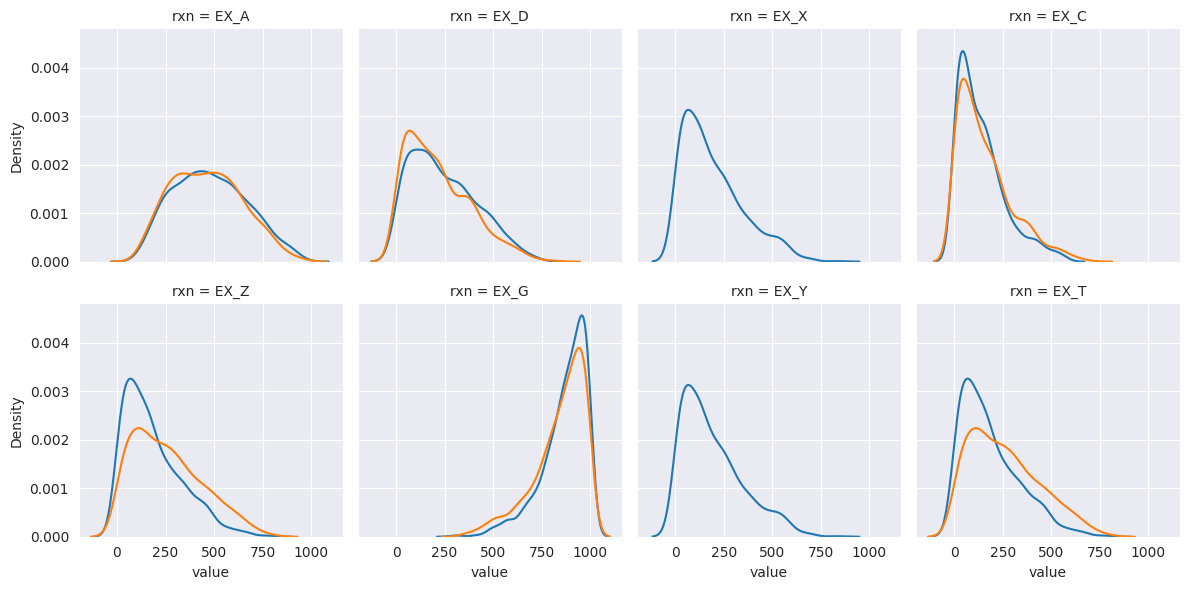

In [97]:
fg = sns.FacetGrid(data=all_samples,
                   col='rxn', col_wrap=4, sharey=True, hue="variable")
fg.map(sns.kdeplot,'value')

In scenario_1, we KOd REF1, which is the sole reaction capable of using metabolites X and Y. We can see in the samples that EX_X and EX_Y are both at 0 flux, as they are no longer able to be imported or exported.

## Z-scores
Z-scores are calculated for each exchange reaction (and therefore each metabolite) by comparing the distribution in the KO state to the distribution in the WT state.
A z-score is therefore representative of how much a metabolite's import/export has shifted in the KO compared to the WT. A positive z-score means that that metabolite is more exported in the KO than the WT.

In [16]:
z_score_file_paths = []
for scenario, rxns_to_ko in ko_dict.items():
    calc_zscore.main(["-i", out_path+"raw_samples/default__sampling__WT.csv.gz", "-j", out_path+"raw_samples/"+scenario+"__sampling__KO.csv.gz", "-o", out_path+"zscores/"+scenario+"_zscores.tsv", "-p", scenario])
    z_score_file_paths.append(out_path+"zscores/"+scenario+"_zscores.tsv")

In [14]:
ko1_zscores = pd.read_csv(out_path+"zscores/scenario_1_zscores.tsv", sep="\t")
ko1_zscores

Metab  scenario_1
0  EX_A   -0.068646
1  EX_D   -0.120707
2  EX_X   -1.246064
3  EX_C    0.106662
4  EX_Z    0.327636
5  EX_G   -0.145701
6  EX_Y   -1.246064
7  EX_T    0.327636

/tmp/ipykernel_342179/4280390373.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  fg = sns.displot(all_samples, kind="kde", x='value', col='rxn', col_wrap=4, hue="variable")
/tmp/ipykernel_342179/4280390373.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  fg = sns.displot(all_samples, kind="kde", x='value', col='rxn', col_wrap=4, hue="variable")


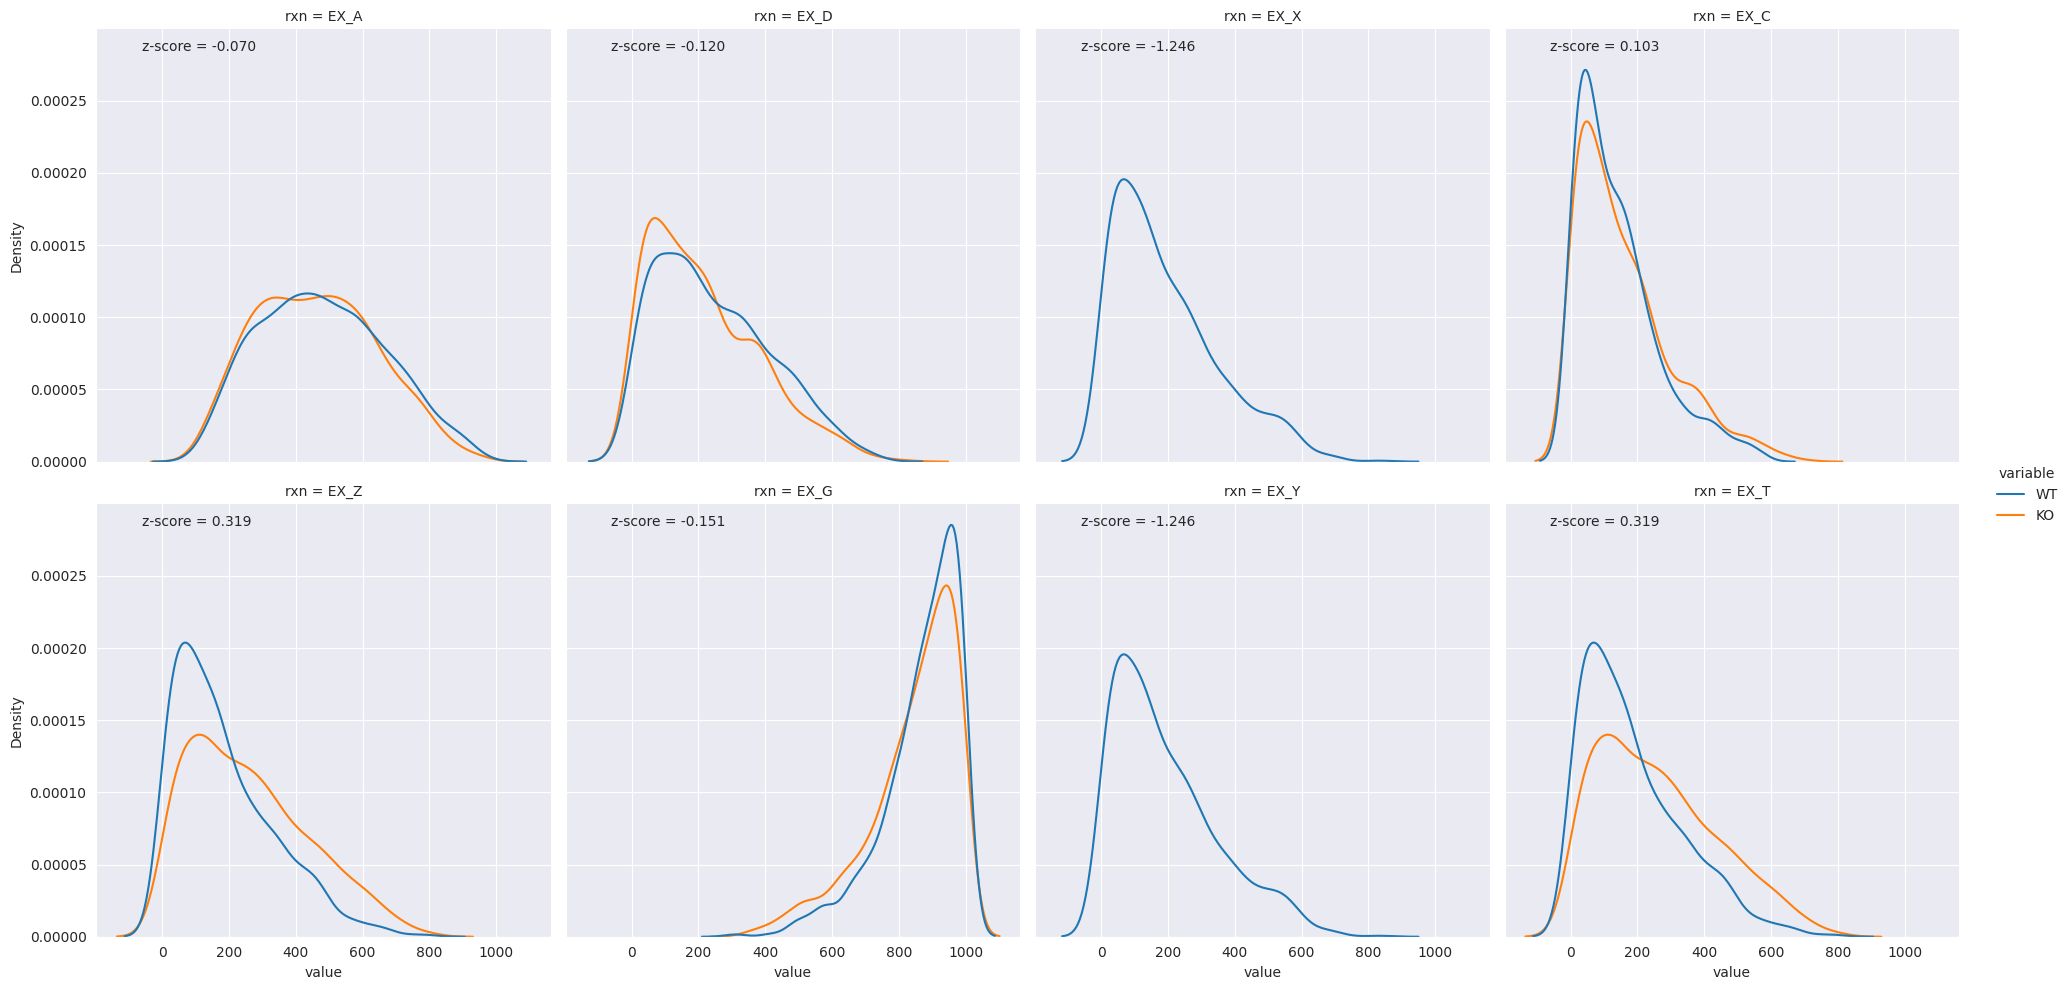

In [114]:
fg = sns.displot(all_samples, kind="kde", x='value', col='rxn', col_wrap=4, hue="variable")
axes = fg.axes.flatten()
for i, ax in enumerate(axes):
    ax.text(0.1, 0.95, "z-score = {:.3f}".format(ko1_zscores.iloc[i, 1]), transform=ax.transAxes)

Metabolites X and Y have a strong negative z-score, meaning they are less exported in the KO state than in the WT state. In this extreme case, we know that they are not imported or exported (0 flux) at all in the KO state.
The other metabolites have low z-scores, mostly due to the variability between samples. Metabolites Z and T are the most affected after X and Y.

Append the z-scores from each KO scenario together.

In [18]:
append_zscores.main(["-i", z_score_file_paths, "-o", out_path+"output/zscores.tsv", "-l"])
all_zscores = pd.read_csv(out_path+"output/zscores.tsv", sep="\t")
all_zscores

Metab  scenario_1  scenario_2  scenario_3
0  EX_A   -0.038672   -2.592180   -0.461838
1  EX_D   -0.105225    1.311544    0.055927
2  EX_X   -1.269794    0.013273   -1.269794
3  EX_C    0.093357    0.317899    0.242431
4  EX_Z    0.282509    0.009925    0.449706
5  EX_G   -0.104048   -0.327428   -0.305645
6  EX_Y   -1.269794    0.013273   -1.269794
7  EX_T    0.282509    0.009925    0.449706

In scenario 2, we KOd the RAB reaction, which is the only reaction that uses A directly. When it is KOd, A is increased in the extracellular medium, as in the WT it was being imported.

## Metabolite dictionary

Creates a dictionary mapping all exchange reactions to metabolite IDs and names. In this model, metabolites don't have a separate name, so it is the same as the ID.

In [5]:
export_dicts.main(["-m", model_path, "--createmetabdict", out_path+"dict/metab_dict.tsv"])

In [6]:
pd.read_csv(out_path+"dict/metab_dict.tsv", sep="\t")

ID Name metabID
0  EX_A  A_e     A_e
1  EX_D  D_e     D_e
2  EX_X  X_e     X_e
3  EX_C  C_e     C_e
4  EX_Z  Z_e     Z_e
5  EX_G  G_e     G_e
6  EX_Y  Y_e     Y_e
7  EX_T  T_e     T_e

# Command line equivalent
SAMBA, as it was intended to be used, runs each automatically step using Snakemake through the command line. It can be run locally on small models but it is best to run it on a computing cluster for larger models.

The Snakemake graph (DAG) is as follows:

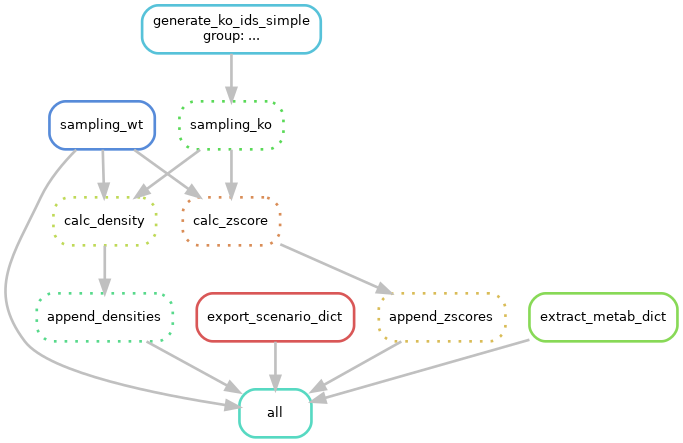

In [8]:
Image(filename='dag.png')

The dotted line cells are the dynamic steps. This means that there will be a variable number of jobs run depending on how many KOs we want to test from this single command line.

The full version of this graph for our example of 3 KO scenarios is:

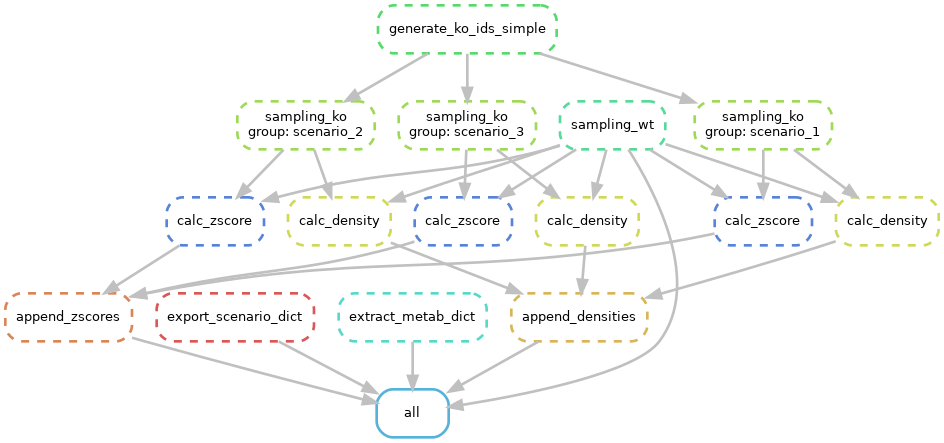

In [10]:
Image(filename='dag_tutorial.png')

The dashed lines mean that the files existed at the time of generating the graph.

The command line version of SAMBA requires the installation of the `sambaflux` python package, as well as the CPLEX solver. It also requires Python 3.7, `cobrapy` and Snakemake.
Instructions can be found [here](https://forgemia.inra.fr/metexplore/cbm/samba-project/samba).


Once everything is installed, simply run the Snakefile by executing:
- `snakemake --profile local` if on a local machine
- `snakemake --profile default` if on a slurm cluster
